In [1]:
from collections import defaultdict
import json
import operator

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from psutil._common import bytes2human

In [2]:
def load_json(filename):
    with open(filename) as f:
        return json.load(f)
    
def successive_diff(arr):
    """ Generates successive differences in a list.
    
    Example
    -------    
    [1, 5, 2] ⇒　[4, -3]
    
    Note that the first value is discarded
    """
    res = list(map(operator.sub, arr[1:], arr[:-1]))
    return res

def bytesto(b, to, bsize=1024):
    """convert bytes to megabytes, etc.
       sample code:
           print('mb= ' + str(bytesto(314575262000000, 'm')))
       sample output: 
           mb= 300002347.946
    """

    a = {'k' : 1, 'm': 2, 'g' : 3, 't' : 4, 'p' : 5, 'e' : 6 }
    r = float(b)
    for i in range(a[to]):
        r = r / bsize

    return(r)

def combine_dics(dics):
    combined = defaultdict(list)
    for d in dics:
        for k, v in d.items():
            combined[k].append(v)
            
    return combined

In [20]:
class MonitoringParser(object):
    def __init__(self, data, legacy=False):
        self.cpu = {
            'VLAN': {
                'System': [],
            },
            'BSDK': {
                'aicluster.exe': [],
            },
            'ASDK': {
                'SDK_AI_Manager.exe': [],
                'node.exe': [],
                'server.exe': [],
                'HumanFlowMain.exe': [],
                'LatestImageManagementMain.exe': [],
                'AVSmart_AnalyticalServer.exe': [],
                'python.exe': [],
                'postgres.exe': [],
            },
            'Others': {
                'others': [],
            },
        }
        
        self.system_cpu = []
        
        self.memory = []
        
        self.netio = {
            'VLAN': {
                'Sent': [],
                'Received': [],
            },
            'PLAN': {
                'Sent': [],
                'Received': [],
            },
        }
        
        self.disk = {
            'C': {
                'Read': [],
                'Write': [],
            },
            'D': {
                'Read': [],
                'Write': [],    
            }
        }
        
        self.elapsed = []
        
        self._init(data, legacy)
        
    def _init(self, data, legacy=False):
        for row_number, row in enumerate(data):
            self._parse_cpu(row_number, row)
            self._parse_system_cpu(row)
            self._parse_memory(row)
            self._parse_netio(row)
            self._parse_disk(row)
            self._parse_elapsed(row)
            
        if not legacy:
            self._compute_others_cpu()
            
        self.netio['VLAN']['Sent'] = successive_diff(self.netio['VLAN']['Sent'])
        self.netio['VLAN']['Received'] = successive_diff(self.netio['VLAN']['Received'])
        
        self.netio['PLAN']['Sent'] = successive_diff(self.netio['PLAN']['Sent'])
        self.netio['PLAN']['Received'] = successive_diff(self.netio['PLAN']['Received'])
        
        self.disk['C']['Read'] = successive_diff(self.disk['C']['Read'])
        self.disk['C']['Write'] = successive_diff(self.disk['C']['Write'])
        
        self.disk['D']['Read'] = successive_diff(self.disk['D']['Read'])
        self.disk['D']['Write'] = successive_diff(self.disk['D']['Write'])
    
    def _parse_cpu(self, row_number, row):
        others = 0.0
        to_add = {}
        for process_number, process in enumerate(row['processes']):
            # We dont want any of that shit
            if process['name'] == 'System Idle Process':
                continue
            
            # We dont want any of this shit either
            # (This is the monitoring process)
            if process['exe'] == 'C:\\Program Files\\Python37\\python.exe':
                continue

            found = False
            for parent, children in self.cpu.items():
                if process['name'] in children:
                    found = True

                    if parent not in to_add:
                        to_add[parent] = {}

                    if process['name'] not in to_add[parent]:
                        to_add[parent][process['name']] = []

                    to_add[parent][process['name']].append(process['cpu_usage'])
                    break

            if not found:
                others += process['cpu_usage']

        if 'Others' not in to_add:
            to_add['Others'] = {}

        if 'others' not in to_add['Others']:
            to_add['Others']['others'] = []

        to_add['Others']['others'].append(others)
        others = 0.0

        # Take into account processes that appear multiple times
        for parent, children in to_add.items():
            for child, cpu_usages in children.items():
                self.cpu[parent][child].append(sum(cpu_usages))

        # If there are processes that didn't appear, append a 0.0
        for children in self.cpu.values():
            for cpu_usages in children.values():
                if len(cpu_usages) < (row_number + 1):
                    cpu_usages.append(0.0)
    
    def _parse_system_cpu(self, row):
        try:
            system_cpu = ave(row['cpu'])
            self.system_cpu.append(system_cpu)
        except:
            # Fail silently
            pass
                    
    def _parse_memory(self, row):
        memory = row['memory']
        self.memory.append(memory[3])
        
    def _parse_netio(self, row):
        vlan_sent = row['net_io']['イーサネット 3'][0]
        vlan_received = row['net_io']['イーサネット 3'][1]
    
        self.netio['VLAN']['Sent'].append(vlan_sent)
        self.netio['VLAN']['Received'].append(vlan_received)
        
        plan_sent = row['net_io']['イーサネット 2'][0]
        plan_received = row['net_io']['イーサネット 2'][1]
        
        self.netio['PLAN']['Sent'].append(plan_sent)
        self.netio['PLAN']['Received'].append(plan_received)
        
    def _parse_disk(self, row):
        c_disk_read = row['disk']['PhysicalDrive0'][2]
        c_disk_write = row['disk']['PhysicalDrive0'][3]
        
        self.disk['C']['Read'].append(c_disk_read)
        self.disk['C']['Write'].append(c_disk_write)
        
        d_disk_read = row['disk']['PhysicalDrive1'][2]
        d_disk_write = row['disk']['PhysicalDrive1'][3]
        
        self.disk['D']['Read'].append(d_disk_read)
        self.disk['D']['Write'].append(d_disk_write)
        
    def _parse_elapsed(self, row):
        elapsed = row['elapsed']
        self.elapsed.append(elapsed)
        
    def _compute_others_cpu(self):
        usages_by_component = self.usages_by_component(use_ave=False)
                
        total = [sum(item) for item in zip(*usages_by_component.values())]
        others = [sys - tot for sys, tot in zip(self.system_cpu, total)]
        self.cpu['Others']['others'] = others
        
    def usages_by_block(self, use_ave=True):
        usages_by_block = {}
        for k, v in self.cpu.items():
            total = [sum(vals) for vals in zip(*list(v.values()))]
            if use_ave:
                usages_by_block[k] = ave(total)
            else:
                usages_by_block[k] = total
        
        return usages_by_block
        
    def usages_by_component(self, use_ave=True):
        usages_by_component = {}
        for k, v in self.cpu.items():
            for c, v2 in v.items():
                if use_ave:
                    usages_by_component[c] = ave(v2)
                else:
                    usages_by_component[c] = v2
        
        return usages_by_component
        
    def total_cpu(self):
        extracted = []
        for parent_p, child_ps in self.cpu.items():
            for child_p, usage in child_ps.items():
                extracted.append(usage)
        
        return [sum(timeslice) for timeslice in zip(*extracted)]
    
    def average_elapsed(self):
        return sum(self.elapsed) / len(self.elapsed)

In [24]:
ave = lambda arr: sum(arr) / len(arr)

class Stats():
    def __init__(self):
        self.ave_cpu = []
        self.ave_memory = []
        self.ave_vlan_sent = []
        self.ave_vlan_rec = []
        self.ave_plan_sent = []
        self.ave_plan_rec = []
        self.ave_c_read = []
        self.ave_c_write = []
        self.ave_d_read = []
        self.ave_d_write = []
        
    def calculate_averages(self, data, legacy=False):
        for datum in data:
            mp = MonitoringParser(datum, legacy)

            if legacy:
                total_cpu = mp.total_cpu()
            else:
                total_cpu = mp.system_cpu
                
            self.ave_cpu.append(ave(total_cpu))

            total_memory = mp.memory
            total_memory_mega = [bytesto(byte, 'm') for byte in total_memory]
            self.ave_memory.append(ave(total_memory_mega))

            netio = mp.netio
            vlan = netio['VLAN']
            plan = netio['PLAN']
            vlan_sent = [bytesto(byte, 'm') for byte in vlan['Sent']]
            vlan_rec = [bytesto(byte, 'm') for byte in vlan['Received']]
            plan_sent = [bytesto(byte, 'm') for byte in plan['Sent']]
            plan_rec = [bytesto(byte, 'm') for byte in plan['Received']]

            self.ave_vlan_sent.append(ave(vlan_sent)/mp.average_elapsed())
            self.ave_vlan_rec.append(ave(vlan_rec)/mp.average_elapsed())
            self.ave_plan_sent.append(ave(plan_sent)/mp.average_elapsed())
            self.ave_plan_rec.append(ave(plan_rec)/mp.average_elapsed())

            disk = mp.disk
            c = disk['C']
            d = disk['D']
            c_read = [bytesto(byte, 'm') for byte in c['Read']]
            c_write = [bytesto(byte, 'm') for byte in c['Write']]
            d_read = [bytesto(byte, 'm') for byte in d['Read']]
            d_write = [bytesto(byte, 'm') for byte in d['Write']]

            self.ave_c_read.append(ave(c_read)/mp.average_elapsed())
            self.ave_c_write.append(ave(c_write)/mp.average_elapsed())
            self.ave_d_read.append(ave(d_read)/mp.average_elapsed())
            self.ave_d_write.append(ave(d_write)/mp.average_elapsed())
            
    def to_df(self, index=None):
        data = {
            'ave_cpu': self.ave_cpu,
            'ave_memory': self.ave_memory,
            'ave_vlan_sent': self.ave_vlan_sent,
            'ave_vlan_rec': self.ave_vlan_rec,
            'ave_plan_sent': self.ave_plan_sent,
            'ave_plan_rec': self.ave_plan_rec,
            'ave_c_read': self.ave_c_read,
            'ave_c_write': self.ave_c_write,
            'ave_d_read': self.ave_d_read,
            'ave_d_write': self.ave_d_write
        }
        
        return pd.DataFrame(data, index=index)

# Average Resource Usages

## 2 People

### Legacy

In [66]:
base = '../_data/story_time/2_people/_legacy/'
folders = ('1', '2', '8', '9', '10', '11', '12')
filename = 'processmonitor.json'

data = []
for folder in folders:
    path = base + folder + f'/{filename}'
    data.append(load_json(path))

s = Stats()
s.calculate_averages(data, legacy=True)

In [67]:
s.to_df(index=map(int, folders))

,ave_cpu,ave_memory,ave_vlan_sent,ave_vlan_rec,ave_plan_sent,ave_plan_rec,ave_c_read,ave_c_write,ave_d_read,ave_d_write
1,8.128750,3871.834180,7.907202,0.030625,0.000184,0.001002,0.000963,0.383047,0.0,0.081247
2,14.733750,4247.676055,15.811991,0.059743,0.000362,0.001861,0.954527,0.665042,0.0,0.167206
8,59.534750,5384.850859,62.767531,0.232774,0.001425,0.007831,0.001534,1.538858,0.0,0.646460
9,68.877375,5673.783828,70.127921,0.260359,0.001589,0.008172,0.002552,2.088080,0.0,0.699711
10,76.501500,6045.054727,78.253855,0.289560,0.001767,0.008643,0.000243,1.897487,0.0,0.780437
11,83.504500,6172.585547,85.915014,0.318155,0.001944,0.010440,0.000116,2.305200,0.0,0.867105
12,76.109125,6579.863086,63.983678,0.234295,0.002120,0.010385,0.000355,3.418919,0.0,0.882325


In [69]:
s.to_df(index=list(map(int, folders))).to_csv('2_cameras_p1.csv')

### Current

In [70]:
# ここ
base = '../_data/story_time/2_people/'
folders = ('3', '4')
filename = 'processmonitor.json'

data = []
for folder in folders:
    path = base + folder + f'/{filename}'
    data.append(load_json(path))

s2 = Stats()
s2.calculate_averages(data)

In [71]:
# Please change index to number of cameras
s2.to_df(index=[3, 4])

,ave_cpu,ave_memory,ave_vlan_sent,ave_vlan_rec,ave_plan_sent,ave_plan_rec,ave_c_read,ave_c_write,ave_d_read,ave_d_write
3,26.720875,4202.974219,23.668841,0.087771,0.000541,0.002990,0.000554,2.725624,0.0,0.232919
4,32.576125,4330.487930,31.642096,0.117071,0.000719,0.003866,0.000381,0.879519,0.0,0.308050


In [72]:
# Here as well
s2.to_df(index=[3, 4]).to_csv('2_cameras_p2.csv')

## 3 People

### Legacy

In [94]:
# These use legacy logs

base = '../_data/story_time/3_people/_legacy/'
folders = ('1', '2', '3', '4')
filename = 'processmonitor.json'

data = []
for folder in folders:
    path = base + folder + f'/{filename}'
    data.append(load_json(path))

s = Stats()
s.calculate_averages(data, legacy=True)

In [95]:
s.to_df(index=map(int, folders))

,ave_cpu,ave_memory,ave_vlan_sent,ave_vlan_rec,ave_plan_sent,ave_plan_rec,ave_c_read,ave_c_write,ave_d_read,ave_d_write
1,15.356863,4301.423560,7.891974,0.040249,0.000186,0.001927,0.000310,1.715456,0.0,0.114893
2,23.152047,4501.483141,15.793626,0.078856,0.000373,0.003872,0.000294,0.681080,0.0,0.232851
3,32.720500,4715.195859,23.673179,0.117549,0.000546,0.005485,0.000000,1.807454,0.0,0.336155
4,43.415430,4918.050720,31.474416,0.155825,0.000729,0.007323,0.000274,1.058653,0.0,0.452253


In [ ]:
s.to_df(index=map(int, folders)).to_csv('3_cameras_p1.csv')

### Current

In [97]:
files = (
    '../_data/story_time/3_people/8/processmonitor.json',
    '../_data/story_time/3_people/9/processmonitor.json',
)
data = []
for file in files:
    data.append(load_json(file))

s2 = Stats()
s2.calculate_averages(data)

In [98]:
s2.to_df(index=[8, 9])

,ave_cpu,ave_memory,ave_vlan_sent,ave_vlan_rec,ave_plan_sent,ave_plan_rec,ave_c_read,ave_c_write,ave_d_read,ave_d_write
8,85.540000,4895.053789,61.990897,0.304836,0.001437,0.014251,0.033696,2.196624,0.0,0.873789
9,74.062375,5336.451953,47.748040,0.233098,0.001562,0.014931,0.002558,1.675047,0.0,1.000832


In [99]:
s2.to_df(index=[8, 9]).to_csv('3_people_p2.csv')

# I forgot

In [97]:
def upsample(arr, every=4):
    series = pd.Series(arr) / every
    return series.loc[series.index.repeat(every)].values.tolist()

data_files = (
    '../データ/test_sannin/8 camera/8 (ave 3.4s).json',
    '../データ/test_sannin/9 camera/9 (ave 5 seconds).json',
    '../データ/test_sannin/10 camera/10.json'
)
stats = []
for data_file in data_files:
    data = load_json(data_file)
    mp = MonitoringParser(data)
    
    read, write = mp.disk['Read'], mp.disk['Write']
    read_mb = upsample([bytesto(byte, 'm') for byte in read])
    write_mb = upsample([bytesto(byte, 'm') for byte in write])
    sent, received = mp.netio['Sent'], mp.netio['Received']
    sent_mb = upsample([bytesto(byte, 'm') for byte in sent])
    received_mb = upsample([bytesto(byte, 'm') for byte in received])
    memory = [bytesto(byte, 'g') for byte in mp.memory]
    
    stat = (read_mb, write_mb, sent_mb, received_mb, memory)
    stats.append(stat)

# Total CPU Usages by Block

In [57]:
# legacy_base = '../_data/story_time/2_people/_legacy/'
# legacy_folders = ('1', '2', '8', '9', '10', '11', '12')

# ここ！
base = '../_data/story_time/2_people/'
folders = ('3', '4')
filename = 'processmonitor.json'

# legacy_data_files = []
# for folder in legacy_folders:
#     path = legacy_base + folder + f'/{filename}'
#     legacy_data_files.append(path)
    
data_files = []
for folder in folders:
    path = base + folder + f'/{filename}'
    data_files.append(path)

# legacy_usages_by_block = [
#     MonitoringParser(load_json(file), legacy=True).usages_by_block()
#     for file in legacy_data_files
# ]

usages_by_block = legacy_usages_by_block[:2] + [
    MonitoringParser(load_json(file), legacy=False).usages_by_block()
    for file in data_files]
# + legacy_usages_by_block[2:]

usages_by_block = combine_dics(usages_by_block)

In [58]:
# Change to number of cameras
ind = (1, 2, 3, 4, 8, 9, 10, 11, 12)

In [59]:
pd.DataFrame(usages_by_block, index=ind).to_csv('Usages By Block.csv')

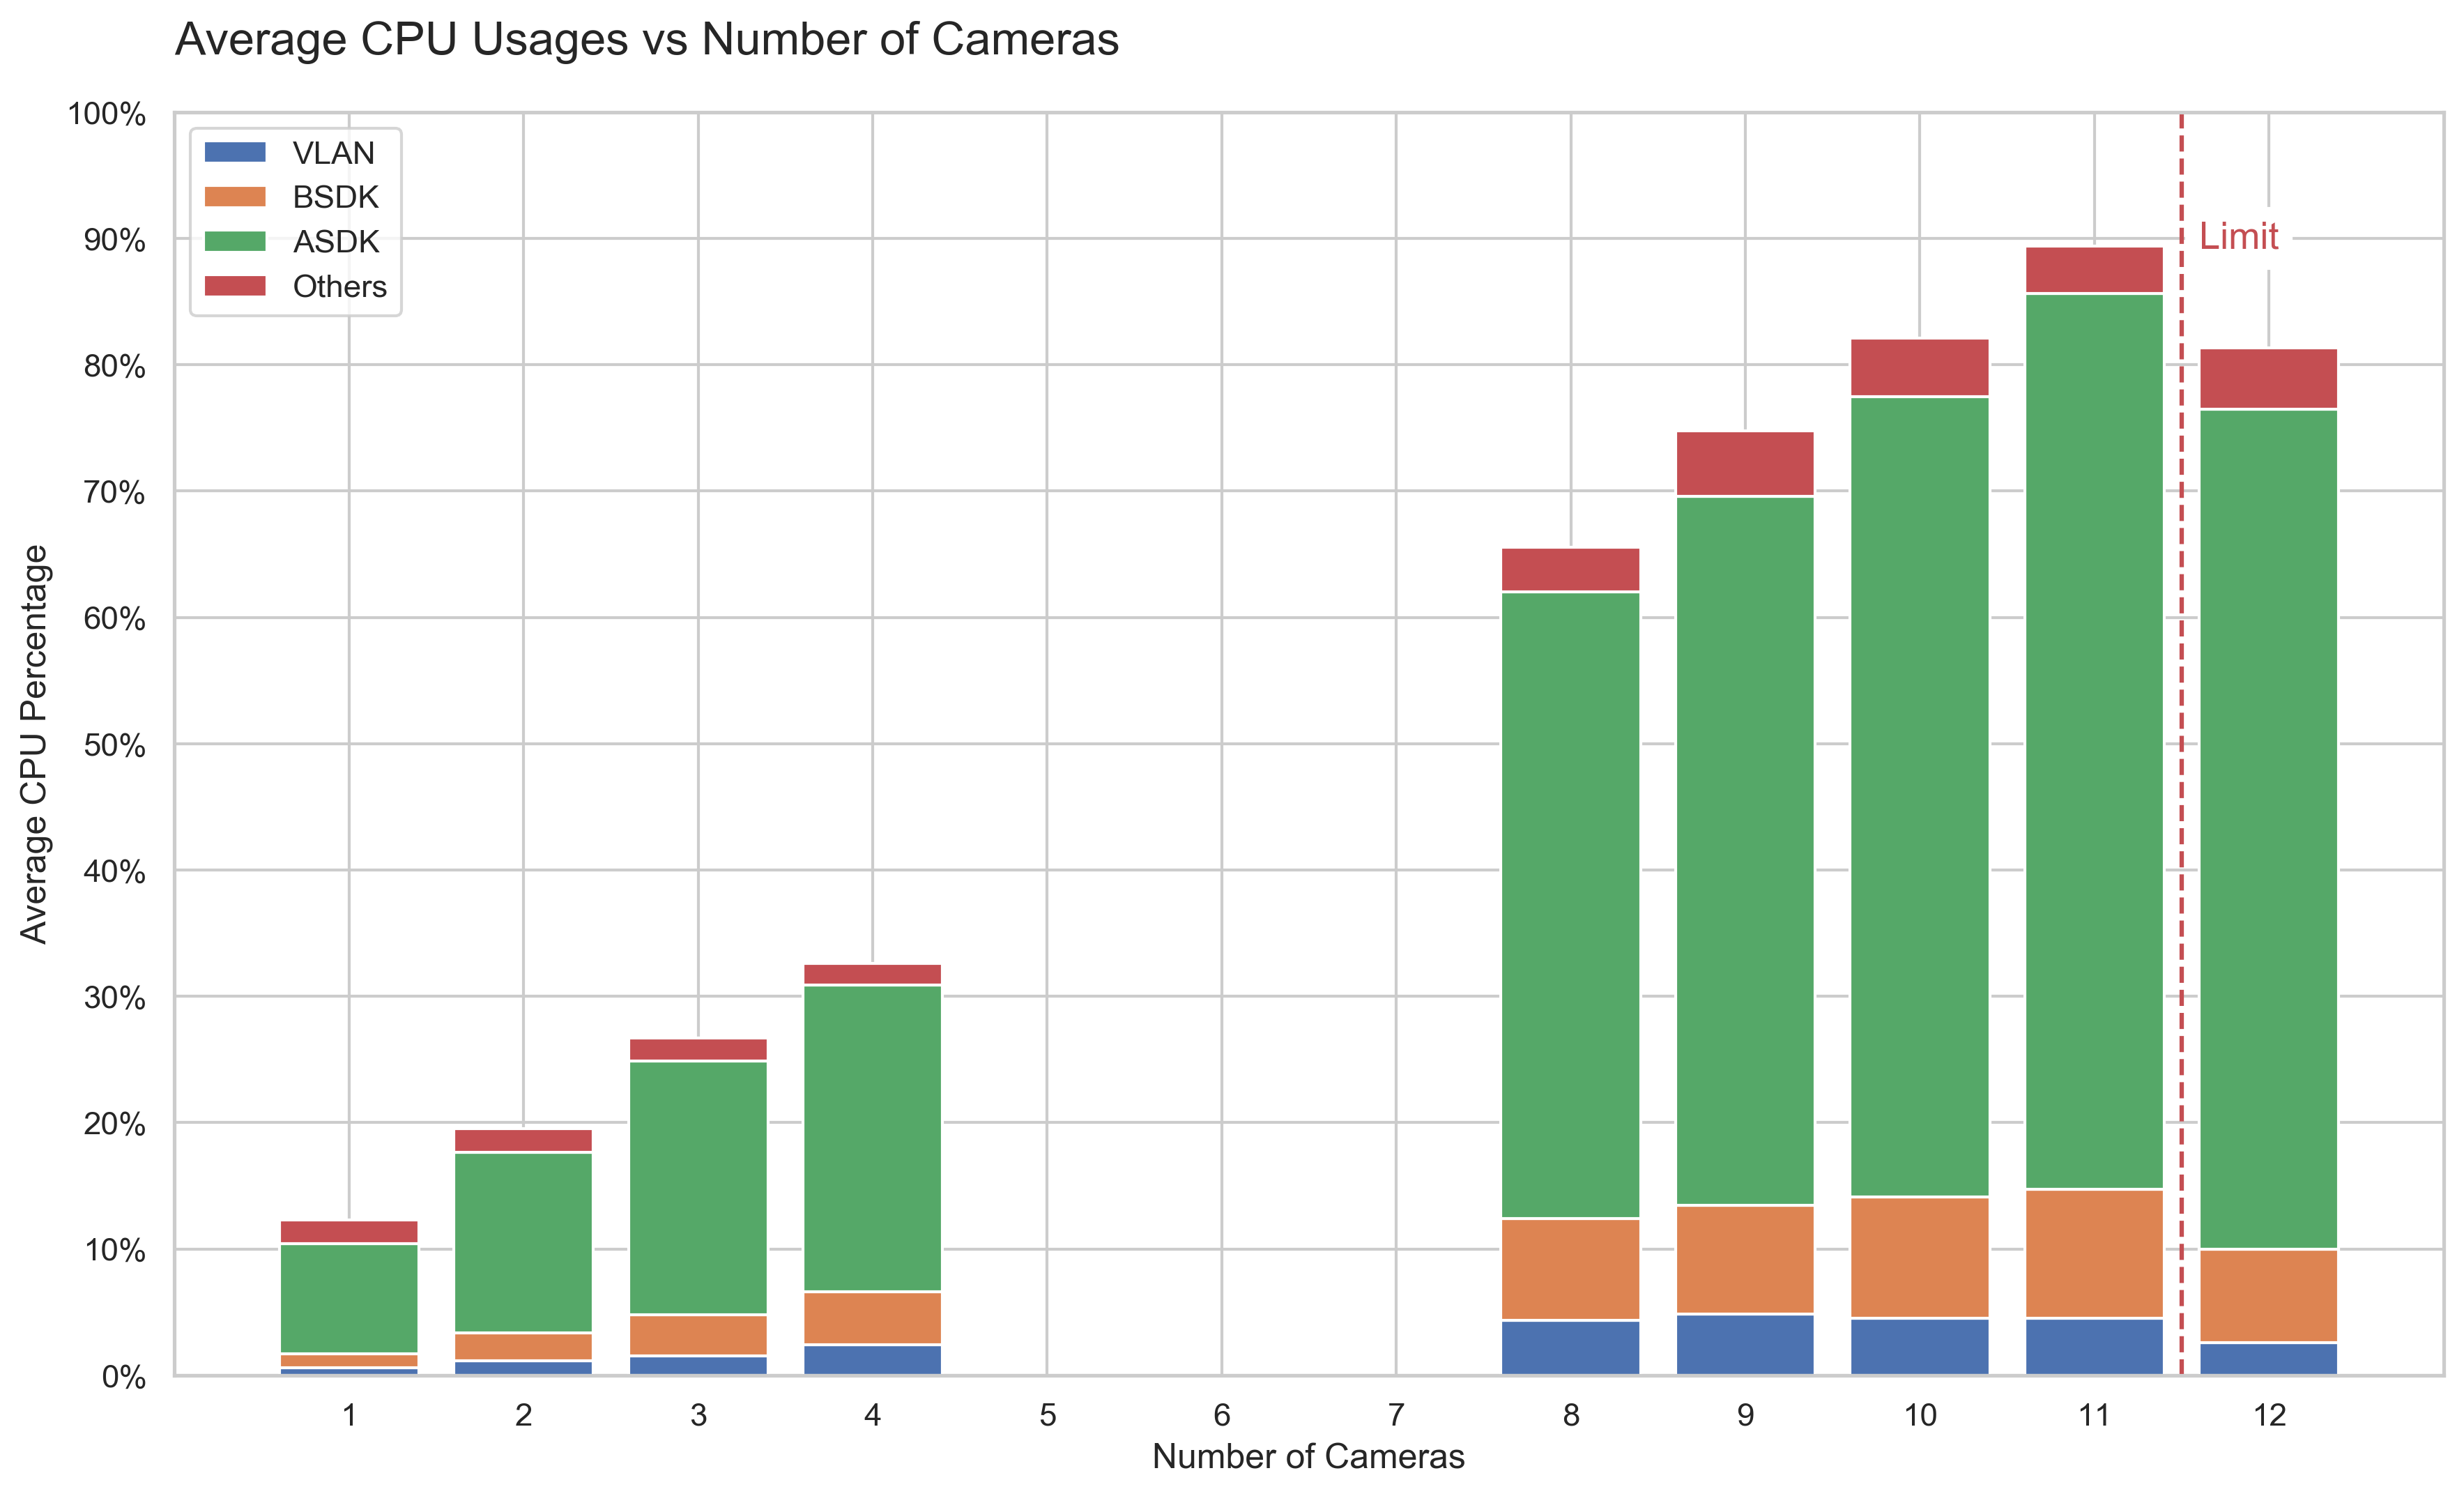

In [135]:
import matplotlib.ticker as mtick
import seaborn as sns; sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(14, 8))

ax.set_title('Average CPU Usages vs Number of Cameras',
             loc='left', fontdict=dict(fontsize=16), pad=20)

ax.grid(True, which='major', axis='y')
ax.set_xlim([0, max(ind) + 1])
ax.set_xticks(range(1, max(ind) + 1))
ax.set_ylim([0, 100])
ax.set_yticks(range(0, 110, 10))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_axisbelow(True)

ax.set_xlabel('Number of Cameras')
ax.set_ylabel('Average CPU Percentage')

vlan_b = ax.bar(ind, usages_by_block['VLAN'])
bsdk_b = ax.bar(ind, usages_by_block['BSDK'], bottom=usages_by_block['VLAN'])
asdk_b = ax.bar(
    ind,
    usages_by_block['ASDK'],
    bottom=[
        x + y
        for x,y
        in zip(usages_by_block['VLAN'], usages_by_block['BSDK'])]
)
others_b = ax.bar(
    ind,
    usages_by_block['Others'],
    bottom = [
        sum(stacked)
        for stacked
        in zip(
            usages_by_block['VLAN'],
            usages_by_block['BSDK'],
            usages_by_block['ASDK']
        )
    ]
)

ax.legend(
    (vlan_b, bsdk_b, asdk_b, others_b),
    ('VLAN', 'BSDK', 'ASDK', 'Others'),
    loc='upper left'
)

# Please modify this... 
ax.axvline(x=11.5, color='r', linestyle='--')
ax.text(x=11.6, y=90,
        s='Limit', color='r', backgroundcolor='white',
        verticalalignment='center', fontsize=13)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.savefig('High-level CPU Usage.png', bbox_inches='tight')

# CPU Usages by Component

In [53]:
# legacy_base = '../_data/story_time/2_people/_legacy/'
# legacy_folders = ('1', '2', '8', '9', '10', '11', '12')
base = '../_data/story_time/2_people/'
folders = ('3', '4')
filename = 'processmonitor.json'

# legacy_data_files = []
# for folder in legacy_folders:
#     path = legacy_base + folder + f'/{filename}'
#     legacy_data_files.append(path)
    
data_files = []
for folder in folders:
    path = base + folder + f'/{filename}'
    data_files.append(path)

# legacy_usages_by_component = [
#     MonitoringParser(load_json(file), legacy=True).usages_by_component()
#     for file in legacy_data_files
# ]

usages_by_component =[
    MonitoringParser(load_json(file), legacy=False).usages_by_component()
    for file in data_files]

usages_by_component = combine_dics(usages_by_component)

usages_by_component['VLAN'] = usages_by_component.pop('System')
usages_by_component['Reference Code'] = usages_by_component.pop('node.exe')
usages_by_component['Surveillance Main'] = usages_by_component.pop('server.exe')
usages_by_component['Surveillance Functions'] = usages_by_component.pop('python.exe')

Found monitoring process
Usage is 0.0
Found monitoring process
Usage is 4.575
Found monitoring process
Usage is 4.2125
Found monitoring process
Usage is 4.2125
Found monitoring process
Usage is 4.3375
Found monitoring process
Usage is 4.65
Found monitoring process
Usage is 4.2125
Found monitoring process
Usage is 4.0375
Found monitoring process
Usage is 4.25
Found monitoring process
Usage is 4.25
Found monitoring process
Usage is 4.125
Found monitoring process
Usage is 4.25
Found monitoring process
Usage is 4.3375
Found monitoring process
Usage is 4.0
Found monitoring process
Usage is 4.0
Found monitoring process
Usage is 4.3375
Found monitoring process
Usage is 4.0375
Found monitoring process
Usage is 4.25
Found monitoring process
Usage is 4.25
Found monitoring process
Usage is 4.25
Found monitoring process
Usage is 4.0
Found monitoring process
Usage is 4.25
Found monitoring process
Usage is 4.125
Found monitoring process
Usage is 4.0375
Found monitoring process
Usage is 4.1625
Found 

Found monitoring process
Usage is 0.0
Found monitoring process
Usage is 4.525
Found monitoring process
Usage is 4.8375
Found monitoring process
Usage is 5.9625
Found monitoring process
Usage is 5.1625
Found monitoring process
Usage is 5.95
Found monitoring process
Usage is 6.1
Found monitoring process
Usage is 5.7
Found monitoring process
Usage is 6.1375
Found monitoring process
Usage is 6.125
Found monitoring process
Usage is 6.4
Found monitoring process
Usage is 6.675
Found monitoring process
Usage is 5.7125
Found monitoring process
Usage is 6.1
Found monitoring process
Usage is 6.225
Found monitoring process
Usage is 5.8625
Found monitoring process
Usage is 6.1375
Found monitoring process
Usage is 6.3375
Found monitoring process
Usage is 6.4
Found monitoring process
Usage is 6.0125
Found monitoring process
Usage is 6.5875
Found monitoring process
Usage is 6.075
Found monitoring process
Usage is 6.1
Found monitoring process
Usage is 6.05
Found monitoring process
Usage is 6.225
Found 

Found monitoring process
Usage is 0.0
Found monitoring process
Usage is 4.975
Found monitoring process
Usage is 4.975
Found monitoring process
Usage is 4.975
Found monitoring process
Usage is 4.6
Found monitoring process
Usage is 4.9875
Found monitoring process
Usage is 5.0875
Found monitoring process
Usage is 5.275
Found monitoring process
Usage is 4.8875
Found monitoring process
Usage is 4.9
Found monitoring process
Usage is 5.1
Found monitoring process
Usage is 5.0875
Found monitoring process
Usage is 5.3
Found monitoring process
Usage is 4.8875
Found monitoring process
Usage is 4.475
Found monitoring process
Usage is 5.3625
Found monitoring process
Usage is 4.7375
Found monitoring process
Usage is 4.4
Found monitoring process
Usage is 5.9375
Found monitoring process
Usage is 5.375
Found monitoring process
Usage is 4.725
Found monitoring process
Usage is 4.45
Found monitoring process
Usage is 4.8875
Found monitoring process
Usage is 5.3125
Found monitoring process
Usage is 5.275
Fou

Found monitoring process
Usage is 3.625
Found monitoring process
Usage is 4.0375
Found monitoring process
Usage is 3.9875
Found monitoring process
Usage is 3.95
Found monitoring process
Usage is 4.075
Found monitoring process
Usage is 4.1625
Found monitoring process
Usage is 3.9
Found monitoring process
Usage is 4.0375
Found monitoring process
Usage is 3.9
Found monitoring process
Usage is 4.0375
Found monitoring process
Usage is 3.95
Found monitoring process
Usage is 4.0375
Found monitoring process
Usage is 3.95
Found monitoring process
Usage is 4.075
Found monitoring process
Usage is 4.075
Found monitoring process
Usage is 4.075
Found monitoring process
Usage is 3.6875
Found monitoring process
Usage is 4.0375
Found monitoring process
Usage is 4.0375
Found monitoring process
Usage is 4.075


In [54]:
ind = (1, 2, 3, 4, 8, 9, 10, 11, 12)

In [55]:
pd.DataFrame(usages_by_component, index=ind).to_csv('Usages By Component.csv')

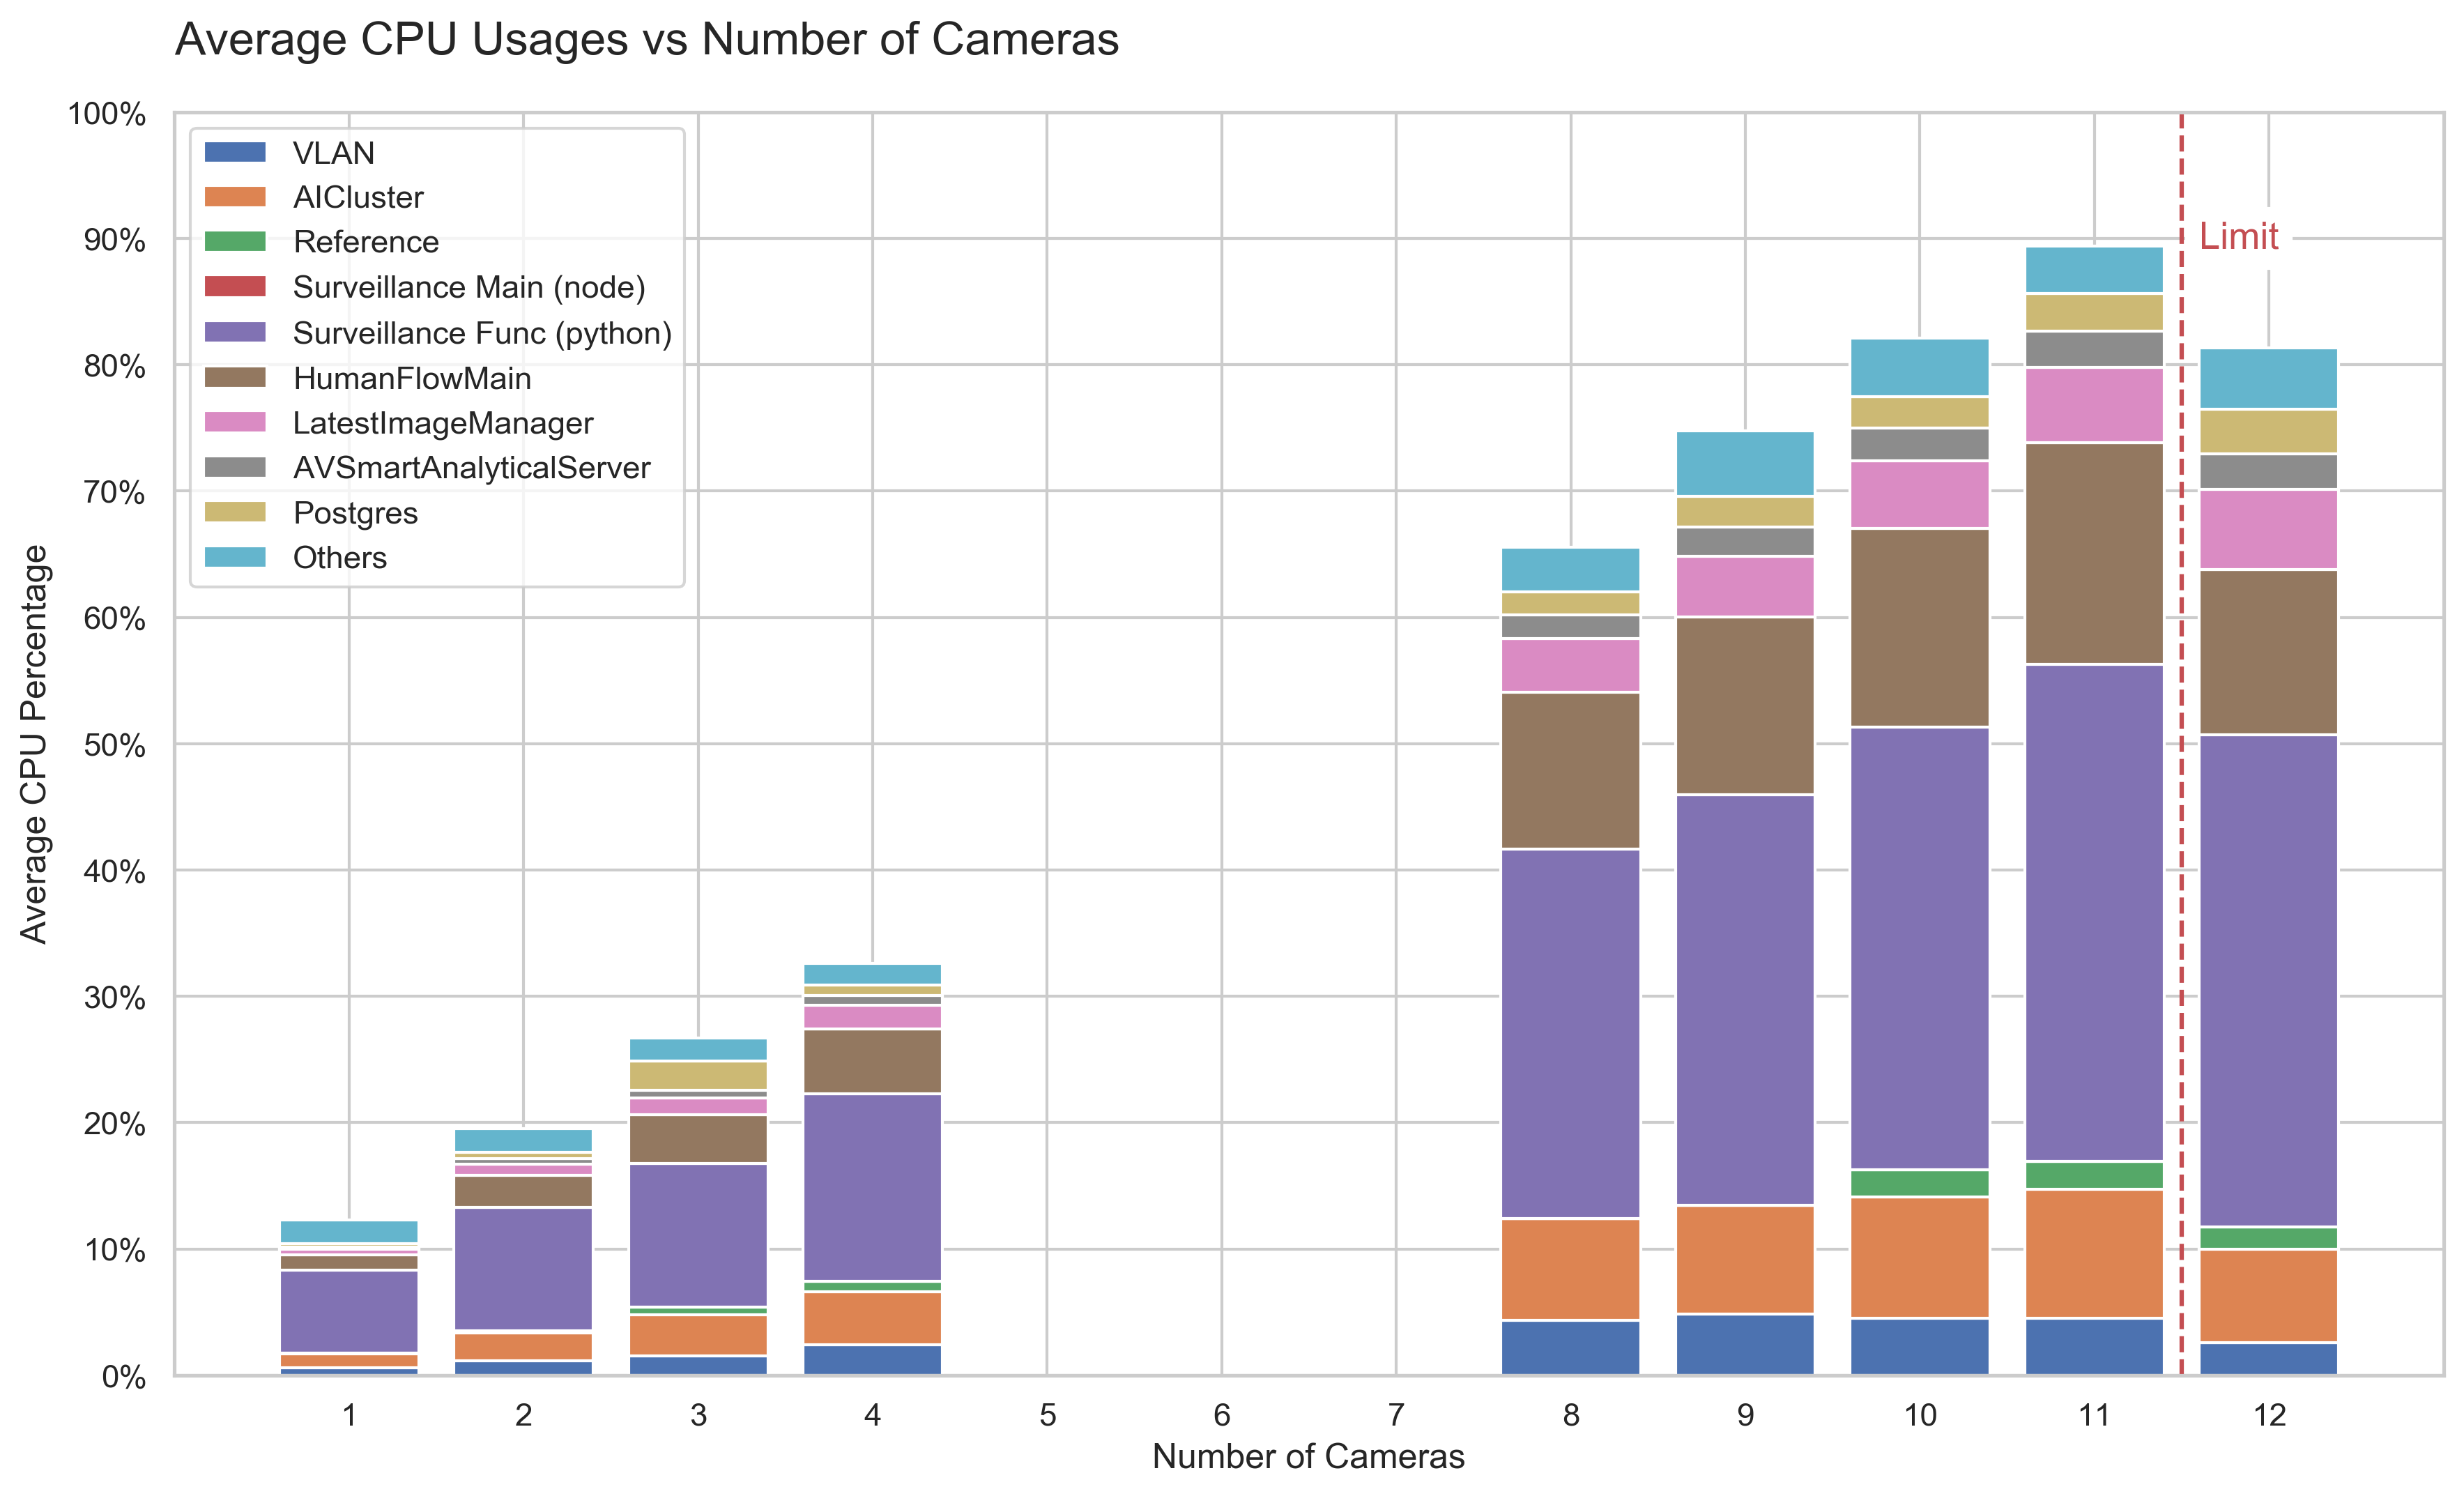

In [138]:
import matplotlib.ticker as mtick
import seaborn as sns; sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(14, 8))

ax.grid(True, which='major', axis='y')
ax.set_xlim([0, max(ind) + 1])
ax.set_xticks(range(1, max(ind) + 1))
ax.set_ylim([0, 100])
ax.set_yticks(range(0, 110, 10))
ax.set_axisbelow(True)
ax.set_title('Average CPU Usages vs Number of Cameras',
             loc='left', fontdict=dict(fontsize=16), pad=20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlabel('Number of Cameras')
ax.set_ylabel('Average CPU Percentage')

vlan_b = ax.bar(
    ind,
    usages_by_component['VLAN']
)

cluster_b = ax.bar(
    ind,
    usages_by_component['aicluster.exe'],
    bottom=(usages_by_component['VLAN'])
)

ref_b = ax.bar(
    ind,
    usages_by_component['Reference Code'],
    bottom=[
        sum(combined)
        for combined
        in zip(
            usages_by_component['VLAN'],
            usages_by_component['aicluster.exe'],
        )
    ]
)

surveillance_main_b = ax.bar(
    ind,
    usages_by_component['Surveillance Main'],
    bottom=[
        sum(combined)
        for combined
        in zip(
            usages_by_component['VLAN'],
            usages_by_component['aicluster.exe'],
            usages_by_component['Reference Code']
        )
    ]
)

surveillance_func_b = ax.bar(
    ind,
    usages_by_component['Surveillance Functions'],
    bottom=[
        sum(combined)
        for combined
        in zip(
            usages_by_component['VLAN'],
            usages_by_component['aicluster.exe'],
            usages_by_component['Reference Code'],
            usages_by_component['Surveillance Main'],
        )
    ]
)

human_flow_main_b = ax.bar(
    ind,
    usages_by_component['HumanFlowMain.exe'],
    bottom=[
        sum(combined)
        for combined
        in zip(
            usages_by_component['VLAN'],
            usages_by_component['aicluster.exe'],
            usages_by_component['Reference Code'],
            usages_by_component['Surveillance Main'],
            usages_by_component['Surveillance Functions'],
        )
    ]
)

latest_image_manager_b = ax.bar(
    ind,
    usages_by_component['LatestImageManagementMain.exe'],
    bottom=[
        sum(combined)
        for combined
        in zip(
            usages_by_component['VLAN'],
            usages_by_component['aicluster.exe'],
            usages_by_component['Reference Code'],
            usages_by_component['Surveillance Main'],
            usages_by_component['Surveillance Functions'],
            usages_by_component['HumanFlowMain.exe'],
        )
    ]    
)

smart_analytical_b = ax.bar(
    ind,
    usages_by_component['AVSmart_AnalyticalServer.exe'],
    bottom=[
        sum(combined)
        for combined
        in zip(
            usages_by_component['VLAN'],
            usages_by_component['aicluster.exe'],
            usages_by_component['Reference Code'],
            usages_by_component['Surveillance Main'],
            usages_by_component['Surveillance Functions'],
            usages_by_component['HumanFlowMain.exe'],
            usages_by_component['LatestImageManagementMain.exe'],
        )
    ]    
)

postgres_b = ax.bar(
    ind,
    usages_by_component['postgres.exe'],
    bottom=[
        sum(combined)
        for combined
        in zip(
            usages_by_component['VLAN'],
            usages_by_component['aicluster.exe'],
            usages_by_component['Reference Code'],
            usages_by_component['Surveillance Main'],
            usages_by_component['Surveillance Functions'],
            usages_by_component['HumanFlowMain.exe'],
            usages_by_component['LatestImageManagementMain.exe'],
            usages_by_component['AVSmart_AnalyticalServer.exe'],
        )
    ]
)

others_b = ax.bar(
    ind,
    usages_by_component['others'],
    bottom=[
        sum(combined)
        for combined
        in zip(
            usages_by_component['VLAN'],
            usages_by_component['aicluster.exe'],
            usages_by_component['Reference Code'],
            usages_by_component['Surveillance Main'],
            usages_by_component['Surveillance Functions'],
            usages_by_component['HumanFlowMain.exe'],
            usages_by_component['LatestImageManagementMain.exe'],
            usages_by_component['AVSmart_AnalyticalServer.exe'],
            usages_by_component['postgres.exe'],
        )
    ]
)

ax.legend(
    (
        vlan_b, cluster_b, ref_b, surveillance_main_b,
        surveillance_func_b, human_flow_main_b, latest_image_manager_b,
        smart_analytical_b, postgres_b, others_b,
    ),
    (
        'VLAN', 'AICluster', 'Reference', 'Surveillance Main (node)',
        'Surveillance Func (python)', 'HumanFlowMain', 'LatestImageManager',
        'AVSmartAnalyticalServer', 'Postgres', 'Others'
    ),
    loc='best'
)

ax.axvline(x=11.5, color='r', linestyle='--')
ax.text(x=11.6, y=90,
        s='Limit', color='r', backgroundcolor='white',
        verticalalignment='center', fontsize=13)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.savefig('Detailed CPU Usage.png', bbox_inches='tight')